In [1]:
import json

In [2]:
with open("../sub_functions.json", 'r') as fp:
    grid_returning_map = json.load(fp)

In [3]:
import ast
import textwrap
from typing import Dict, Any, List, Tuple
import os
import importlib.util


In [4]:
def import_dsl_functions(dsl_file_path: str) -> Dict[str, Any]:
    spec = importlib.util.spec_from_file_location("dsl", dsl_file_path)
    dsl_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dsl_module)
    return {name: getattr(dsl_module, name) for name in dir(dsl_module) if not name.startswith('_')}

def execute_sub_function(sub_function_str: str, input_grid: Tuple[Tuple[int, ...], ...], dsl_functions: Dict[str, Any], constants: Dict[str, Any]) -> Tuple[Tuple[int, ...], ...]:
    # Parse the sub-function string
    sub_function_ast = ast.parse(sub_function_str).body[0].value

    def eval_node(node):
        if isinstance(node, ast.Call):
            func_name = node.func.id
            args = [eval_node(arg) for arg in node.args]
            return dsl_functions[func_name](*args)
        elif isinstance(node, ast.Name):
            if node.id == 'I':
                return input_grid
            elif node.id in constants:
                return constants[node.id]
            elif node.id in dsl_functions:
                return dsl_functions[node.id]
            else:
                raise NameError(f"Name '{node.id}' is not defined")
        elif isinstance(node, ast.Num):
            return node.n
        else:
            raise ValueError(f"Unsupported node type: {type(node)}")

    return eval_node(sub_function_ast)


In [5]:
dsl_functions = import_dsl_functions('dsl.py')

In [6]:
import sys

In [7]:
def read_file(file_path: str) -> str:
    with open(file_path, 'r') as file:
        return file.read()
def parse_constants(code: str) -> Dict[str, Any]:
    tree = ast.parse(code)
    constants = {}
    for node in ast.walk(tree):
        if isinstance(node, ast.Assign):
            for target in node.targets:
                if isinstance(target, ast.Name) and target.id.isupper():
                    if isinstance(node.value, ast.Num):
                        constants[target.id] = node.value.n
                    elif isinstance(node.value, ast.UnaryOp) and isinstance(node.value.op, ast.USub):
                        # Handle negative numbers
                        constants[target.id] = -node.value.operand.n
                    elif isinstance(node.value, ast.Tuple):
                        constants[target.id] = tuple(
                            elt.n if isinstance(elt, ast.Num) 
                            else -elt.operand.n if isinstance(elt, ast.UnaryOp) and isinstance(elt.op, ast.USub)
                            else None 
                            for elt in node.value.elts
                        )
                    elif sys.version_info >= (3, 8) and isinstance(node.value, ast.Constant):
                        # Handle booleans and other constants in Python 3.8+
                        constants[target.id] = node.value.value
                    elif sys.version_info < (3, 8) and isinstance(node.value, ast.NameConstant):
                        # Handle booleans in Python 3.7 and earlier
                        constants[target.id] = node.value.value
    return constants



In [8]:
constants_code = read_file('constants.py')
constants = parse_constants(constants_code)


In [9]:
def references_input_grid(func_def: ast.FunctionDef) -> bool:
    """
    Check if the function references the input grid 'I'.
    
    :param func_def: The AST node of the function definition
    :return: True if the function references 'I', False otherwise
    """
    class InputGridVisitor(ast.NodeVisitor):
        def __init__(self):
            self.references_i = False

        def visit_Name(self, node):
            if node.id == 'I':
                self.references_i = True
            self.generic_visit(node)

    visitor = InputGridVisitor()
    visitor.visit(func_def)
    return visitor.references_i


In [10]:
def plot_task(
    task: List[dict],
    title: str = None
) -> None:
    """
    displays a task
    """
    cmap = ListedColormap([
        '#000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = Normalize(vmin=0, vmax=9)
    args = {'cmap': cmap, 'norm': norm}
    height = 2
    width = len(task)
    figure_size = (width * 3, height * 3)
    figure, axes = plt.subplots(height, width, figsize=figure_size)
    if width > 1:
        for column, example in enumerate(task):
            axes[0, column].imshow(example['input'], **args)
            axes[1, column].imshow(example['output'], **args)
            axes[0, column].axis('off')
            axes[1, column].axis('off')
    else:
        example=task[0]
        axes[0].imshow(example['input'], **args)
        axes[1].imshow(example['output'], **args)
        axes[0].axis('off')
        axes[1].axis('off')
    if title is not None:
        figure.suptitle(title, fontsize=20)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [11]:
def get_data(train=True):
    path = f'arc_original/{"training" if train else "evaluation"}'
    data = {}
    for fn in os.listdir(path):
        with open(f'{path}/{fn}') as f:
            data[fn.rstrip('.json')] = json.load(f)
    ast = lambda g: tuple(tuple(r) for r in g)
    return {
        'train': {k: [{
            'input': ast(e['input']),
            'output': ast(e['output']),
        } for e in v['train']] for k, v in data.items()},
        'test': {k: [{
            'input': ast(e['input']),
            'output': ast(e['output']),
        } for e in v['test']] for k, v in data.items()}
    }


In [12]:
data = get_data()

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize


In [14]:
import numpy as np

In [15]:
with open("incremental_arc_examples.json", 'r') as fp:
    inc_examples = json.load(fp)

with open("incremental_arc_solutions.json", 'r') as fp:
    incr_programs = json.load(fp)

In [16]:
inc_examples['train'].keys()

dict_keys(['5614dbcf_0', 'f25ffba3_0', 'f25ffba3_1', '28bf18c6_0', '28bf18c6_1', '3af2c5a8_0', '3af2c5a8_1', '62c24649_0', '62c24649_1', '67e8384a_0', '67e8384a_1', '7468f01a_0', '46f33fce_0', '46f33fce_1', '46f33fce_2', 'a740d043_0', 'a79310a0_0', 'aabf363d_0', 'aabf363d_1', 'f25fbde4_0', '1e0a9b12_0', '0d3d703e_0', '0d3d703e_1', '0d3d703e_2', '1c786137_0', '2013d3e2_0', '2013d3e2_1', '9565186b_0', 'e98196ab_0', 'e98196ab_1', 'f76d97a5_0', 'ce9e57f2_0', '9f236235_0', '46442a0e_0', '46442a0e_1', '46442a0e_2', '46442a0e_3', '46442a0e_4', '7fe24cdd_0', '7fe24cdd_1', '7fe24cdd_2', '7fe24cdd_3', '7fe24cdd_4', '0ca9ddb6_0', '543a7ed5_0', '0520fde7_0', '0520fde7_1', '0520fde7_2', 'dae9d2b5_0', 'dae9d2b5_1', 'dae9d2b5_2', '8d5021e8_0', '8d5021e8_1', '8d5021e8_2', '8d5021e8_3', '8d5021e8_4', '928ad970_0', '928ad970_1', 'b60334d2_0', 'b60334d2_1', 'b94a9452_0', 'b94a9452_1', 'b94a9452_2', 'd0f5fe59_0', 'e3497940_0', 'e3497940_1', 'e9afcf9a_0', 'e9afcf9a_1', 'e9afcf9a_2', 'e9afcf9a_3', 'e9afcf9a

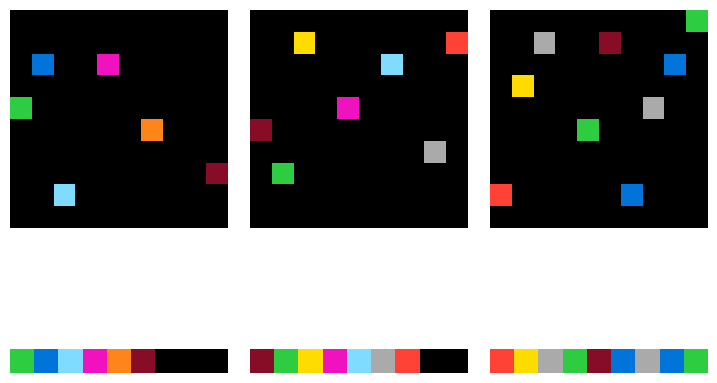

In [31]:
plot_task(inc_examples['train']['cdecee7f_8'])

In [32]:
incr_programs['cdecee7f_8']

'hconcat(dmirror(merge(apply(rbind(canvas, UNITY), apply(color, order(objects(I, T, F, T), leftmost))))), canvas(ZERO, astuple(ONE, subtract(NINE, size(objects(I, T, F, T))))))'

In [22]:
with open("incremental_input_grid_arc_examples.json", 'r') as fp:
    relabeled_examples = json.load(fp)

with open("incremental_input_grid_arc_solutions.json", 'r') as fp:
    relabeled_solns = json.load(fp)

In [33]:
rel_keys = [k for k in relabeled_examples['train'] if 'cdecee7f' in k]

In [34]:
rel_keys

['cdecee7f_incr_input_0',
 'cdecee7f_incr_input_1',
 'cdecee7f_incr_input_2',
 'cdecee7f_incr_input_3',
 'cdecee7f_incr_input_4']

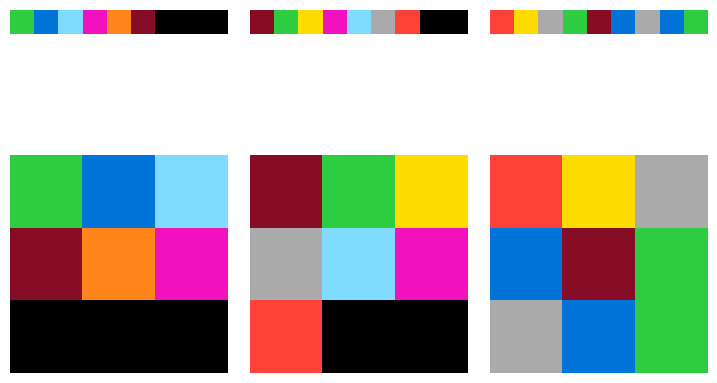

In [36]:
plot_task(relabeled_examples['train']['cdecee7f_incr_input_0'])

In [37]:
relabeled_solns['cdecee7f_incr_input_0']

'vconcat(vconcat(crop(merge(hsplit(I, THREE)), ORIGIN, astuple(ONE, THREE)), vmirror(crop(merge(hsplit(I, THREE)), DOWN, astuple(ONE, THREE)))), crop(merge(hsplit(I, THREE)), TWO_BY_ZERO, astuple(ONE, THREE)))'